# Stochastic Simulations - group project

## Project 4 : Variance reduction in Monte Carlo integration via function approximation

Francesca Bettinelli \
Marianna Dell'Otto \
Sophie Lequeu

In [1]:
from question2 import *
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

### Question 1
See LaTeX report.

### Question 2
#### a) Crude Monte Carlo estimator
We begin by estimating the integral *$I$* using a crude Monte Carlo estimator *$I_{MC}$*.

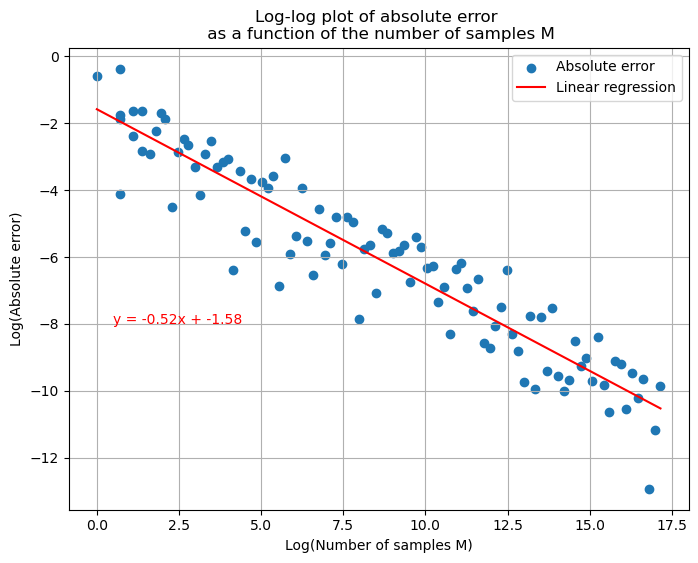

In [10]:
# exact value of the integral (reference)
ref_value = (1/5) * np.arctan(5)

# crude Monte Carlo estimators
N = 100
nb_samples = [math.ceil(np.power(2, 1/4)**n) for n in range(N)]
CMC_estims = np.zeros(N)
for M in range(N):
    unif_samps = np.random.uniform(0, 1, nb_samples[M])
    CMC_estims[M] = crude_MC(unif_samps, f)

# plot log-log graph to see order of the error
loglog_graph(nb_samples, CMC_estims, ref_value)


Plotting the error of the crude Monte Carlo estimator for different values of M (in log-log scale), we observe that it can be approximated by a straight line with slope $\approx 0.5$. We conclude that the error decreases approximately as the square-root of the number of samples M. This is indeed what was expected from a crude Monte Carlo estimator, since it is unbiaised, with variance in $\mathcal{O}(M)$, thus confidence interval in $\mathcal{O}(\sqrt M)$ (from the CLT).

#### b) MCLS
The aim of this second part is to implement the MCLS estimators *$I_{MCLS}$* using an expansion of the Legendre polynomials up to degree n.
We will consider the same values of $M$ (numbers of samples) as in *(a)*, and try different values of $n$ : \
    $n = 1, 2, ...$, \
    $n = \lceil \sqrt M \rceil$, \
    $n = \lceil \frac{M}{2} \rceil$.

In [11]:
ref_value = (1/5) * np.arctan(5)
N = 60
nb_samples = [math.ceil(np.power(2, 1/4)**n) for n in range(N)]

# MCLS estimators
MCLS_estims = np.zeros(N)
MCLS_prime_estims = np.zeros(N)

MCLS_estims3 = np.zeros(N)
MCLS_prime_estims3 = np.zeros(N)

for M in range(N):
    n=2
    #n = np.ceil(np.sqrt(nb_samples[M])).astype(int)
    #n=np.ceil(nb_samples[M])/2).astype(int)
    unif_samps = np.random.uniform(0, 1, nb_samples[M])
    MCLS_estims[M] = MCLS(unif_samps, f,  n)
    MCLS_prime_estims[M] = MCLS_prime(unif_samps, f)

    n=3
    MCLS_estims3[M] = MCLS(unif_samps, f,  n)
    MCLS_prime_estims3[M] = MCLS_prime(unif_samps, f)

MCLS_estims = [MCLS_estims, MCLS_estims3]
MCLS_prime_estims = [MCLS_prime_estims, MCLS_prime_estims3]
    

n =  2
Condition number of the Vandermonde matrix :  1.0
n =  3
Condition number of the Vandermonde matrix :  1.0
n =  2
Condition number of the Vandermonde matrix :  3.877639900947606
n =  3
Condition number of the Vandermonde matrix :  1.952127192475273
n =  2
Condition number of the Vandermonde matrix :  5.360553810778546
n =  3
Condition number of the Vandermonde matrix :  1.461597700348602
n =  2
Condition number of the Vandermonde matrix :  4.5618410992230185
n =  3
Condition number of the Vandermonde matrix :  20.47384917022335
n =  2
Condition number of the Vandermonde matrix :  2.921176109379867
n =  3
Condition number of the Vandermonde matrix :  1.8627633412514684
n =  2
Condition number of the Vandermonde matrix :  2.62053731022975
n =  3
Condition number of the Vandermonde matrix :  13.59261344726293
n =  2
Condition number of the Vandermonde matrix :  4.147166304996893
n =  3
Condition number of the Vandermonde matrix :  1074.7895341099706
n =  2
Condition number of the V

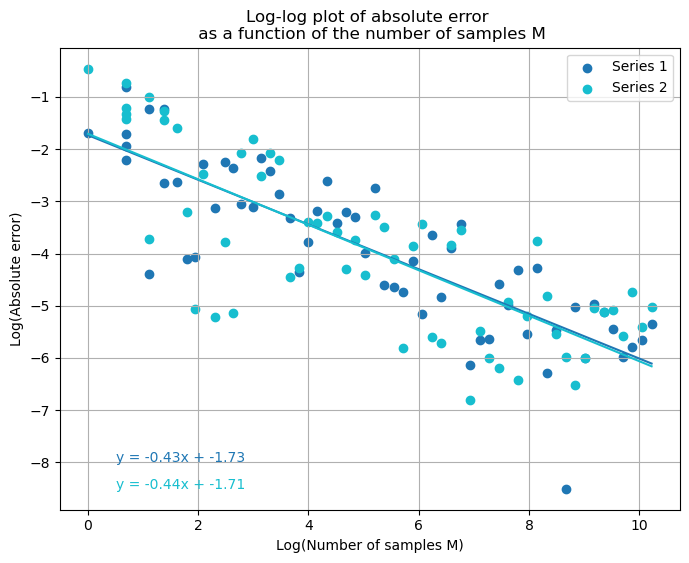

In [12]:
# plot log-log graph to see order of the error
multiple_loglog_graph(nb_samples, MCLS_estims, ref_value)

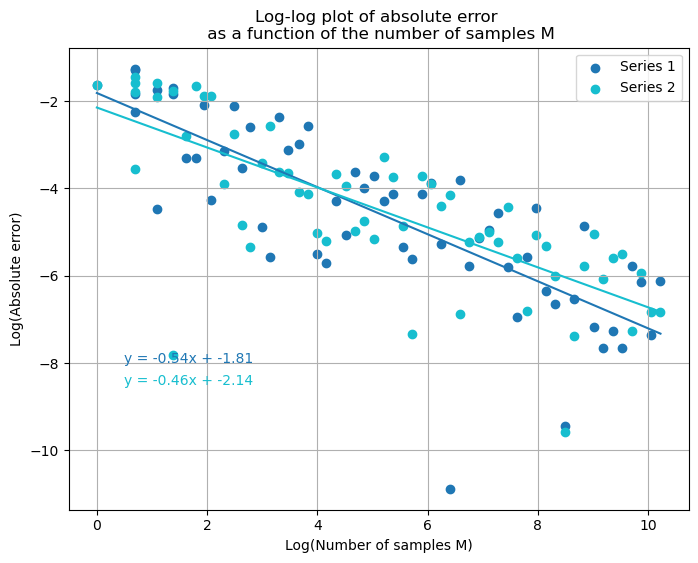

In [13]:
# plot log-log graph to see order of the error
multiple_loglog_graph(nb_samples, MCLS_prime_estims, ref_value)

In [14]:
ref_value = (1/5) * np.arctan(5)
N = 60
nb_samples = [math.ceil(np.power(2, 1/4)**n) for n in range(N)]

# MCLS estimators
MCLS_estims = np.zeros(N)
MCLS_prime_estims = np.zeros(N)

for M in range(N):
    n=1
    #n = np.ceil(np.sqrt(nb_samples[M])).astype(int)
    unif_samps = np.random.uniform(0, 1, nb_samples[M])
    MCLS_estims[M] = MCLS_new(unif_samps, f, n)
    MCLS_prime_estims[M] = MCLS_prime_new(unif_samps, f)

c:\Users\Lenovo\anaconda3\lib\site-packages\numpy\polynomial\legendre.py:1412: RankWarning: The fit may be poorly conditioned
  return pu._fit(legvander, x, y, deg, rcond, full, w)


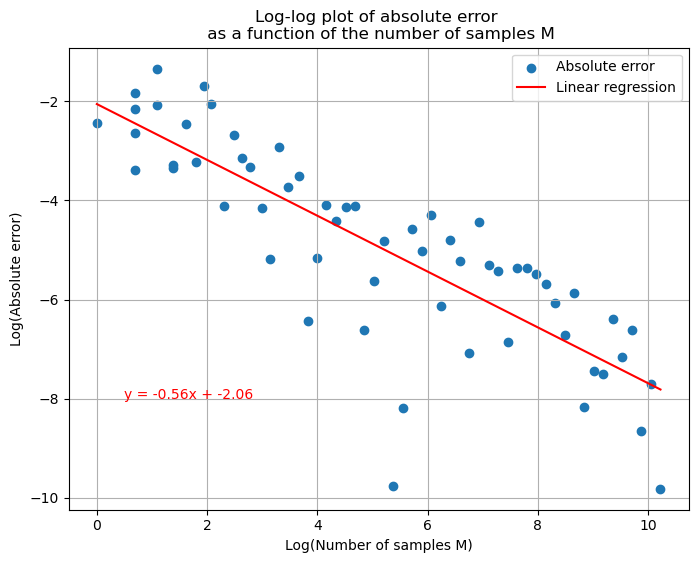

In [15]:
# plot log-log graph to see order of the error
loglog_graph(nb_samples, MCLS_estims, ref_value)

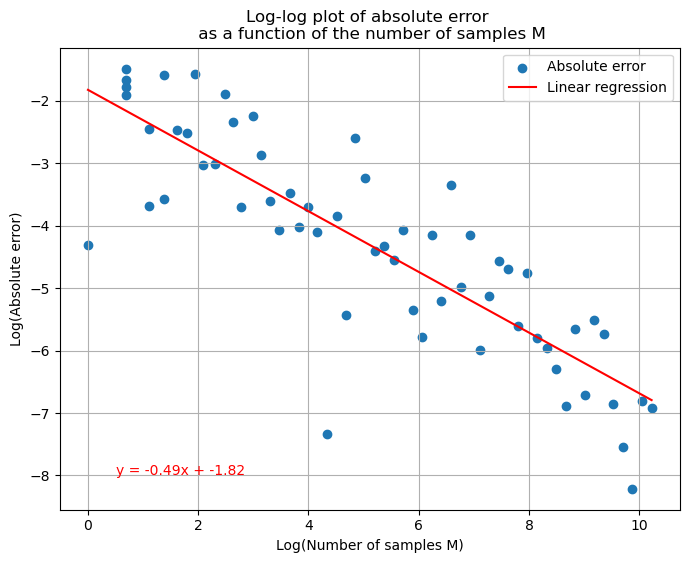

In [16]:
# plot log-log graph to see order of the error
loglog_graph(nb_samples, MCLS_prime_estims, ref_value)